## EDA

### 1. Load datasets

In [80]:
import pandas as pd

train_df = pd.read_csv('../data/raw/HouseTS_train.csv')
validation_df = pd.read_csv('../data/raw/HouseTS_validation.csv')
test_df = pd.read_csv('../data/raw/HouseTS_test.csv')

metros_df = pd.read_csv('../data/raw/usmetros.csv')

### 2. Location Processing

In [81]:
metros_df.head()

,metro_fips,metro,metro_ascii,metro_full,county_name,county_fips,state_id,state_name,lat,lng,population
0,35620,New York,New York,"New York-Newark-Jersey City, NY-NJ",Suffolk,36103,NY,New York,40.7222,-74.0225,19498249
1,31080,Los Angeles,Los Angeles,"Los Angeles-Long Beach-Anaheim, CA",Los Angeles,6037,CA,California,34.2215,-118.1494,12799100
2,16980,Chicago,Chicago,"Chicago-Naperville-Elgin, IL-IN",Cook,17031,IL,Illinois,41.6675,-87.9597,9262559
3,19100,Dallas,Dallas,"Dallas-Fort Worth-Arlington, TX",Denton,48121,TX,Texas,32.8495,-96.9704,8100037
4,26420,Houston,Houston,"Houston-Pasadena-The Woodlands, TX",Harris,48201,TX,Texas,29.8422,-95.3855,7510252


In [82]:
print("Unique metro_full values:", len(metros_df['metro_full'].unique()))
metros_df['metro_full'].unique()[:5]

Unique metro_full values: 387


array(['New York-Newark-Jersey City, NY-NJ',
       'Los Angeles-Long Beach-Anaheim, CA',
       'Chicago-Naperville-Elgin, IL-IN',
       'Dallas-Fort Worth-Arlington, TX',
       'Houston-Pasadena-The Woodlands, TX'], dtype=object)

In [83]:
print("Unique city_full values:", len(train_df['city_full'].unique()))
train_df['city_full'].unique()[:5]


Unique city_full values: 30


array(['Atlanta-Sandy Springs-Alpharetta', 'Pittsburgh',
       'Boston-Cambridge-Newton', 'Tampa-St. Petersburg-Clearwater',
       'Baltimore-Columbia-Towson'], dtype=object)

Action: Non-consitencies in `city_full` and `metro_full` columns have been identified. We will clean these columns to ensure consistency across the dataset, by removing state information from `metro_full` and standardizing `city_full`.

In [84]:
# Edit metro_full to keep only the metro name without the state (after the comma)
metros_df['metro_full'] = metros_df['metro_full'].apply(lambda x: x.split(',')[0] if pd.notnull(x) else x)
metros_df['metro_full'].unique()[:5]

array(['New York-Newark-Jersey City', 'Los Angeles-Long Beach-Anaheim',
       'Chicago-Naperville-Elgin', 'Dallas-Fort Worth-Arlington',
       'Houston-Pasadena-The Woodlands'], dtype=object)

In [85]:
# How much mismatch is there between the metros in the train/validation/test sets and the metros in the metros_df?
house_ts_metros = pd.concat([train_df['city_full'], validation_df['city_full'], test_df['city_full']]).unique()
usmetros_metros = metros_df['metro_full'].unique()

mismatched_metros = []
for metro in house_ts_metros:
    if metro not in usmetros_metros:
        mismatched_metros.append(metro)

mismatched_metros


['Atlanta-Sandy Springs-Alpharetta',
 'San Francisco-Oakland-Berkeley',
 'Austin-Round Rock-Georgetown',
 'Houston-The Woodlands-Sugar Land',
 'Denver-Aurora-Lakewood',
 'DC_Metro',
 'Las Vegas-Henderson-Paradise',
 'Miami-Fort Lauderdale-Pompano Beach']

In [86]:
# Fix mismatched metros
city_mapping = {
    'Las Vegas-Henderson-Paradise': 'Las Vegas-Henderson-North Las Vegas',
    'Denver-Aurora-Lakewood': 'Denver-Aurora-Centennial',
    'Houston-The Woodlands-Sugar Land': 'Houston-Pasadena-The Woodlands',
    'Austin-Round Rock-Georgetown': 'Austin-Round Rock-San Marcos',
    'Miami-Fort Lauderdale-Pompano Beach': 'Miami-Fort Lauderdale-West Palm Beach',
    'San Francisco-Oakland-Berkeley': 'San Francisco-Oakland-Fremont',
    'DC_Metro': 'Washington-Arlington-Alexandria',
    'Atlanta-Sandy Springs-Alpharetta': 'Atlanta-Sandy Springs-Roswell'
}

def clean_merge_citydata(df):
    df['city_full'] = df['city_full'].replace(city_mapping)

    df = df.merge(metros_df[['metro_full', 'lat', 'lng']]
                  , how='left', left_on='city_full', right_on='metro_full')
    df = df.drop(columns=['metro_full'])

    missing = df[df['lat'].isnull()]['city_full'].unique()
    print("Missing metros after merge:", len(missing))
    return df

In [87]:
train_df = clean_merge_citydata(train_df)
validation_df = clean_merge_citydata(validation_df)

Missing metros after merge: 0
Missing metros after merge: 0


### 3. Clean Duplicates

In [88]:
def find_duplicates(df):
    duplicates = df[df.duplicated()]
    duplicates_without_date = df[df.duplicated(subset=df.columns.difference(['date']))]
    display(duplicates_without_date.head(2))
    print("Number of duplicate rows (all columns):", len(duplicates))
    print("Number of duplicate rows (excluding date):", len(duplicates_without_date))

find_duplicates(train_df)
find_duplicates(validation_df)

,date,median_sale_price,median_list_price,median_ppsf,median_list_ppsf,homes_sold,pending_sales,new_listings,inventory,median_dom,...,Median Home Value,Total Labor Force,Unemployed Population,Total School Age Population,Total School Enrollment,Median Commute Time,price,city_full,lat,lng
6236,2012-04-30,97500.0,139900.0,88.315217,110.680380,1.0,0.0,1.0,3.0,52.0,...,99300.0,812.0,7.0,1213.0,1213.0,736.0,121327.945452,St. Louis,38.7352,-90.3501
6242,2012-04-30,4000.0,6500.0,2.628121,4.461447,39.0,38.0,54.0,73.0,115.5,...,58400.0,11895.0,3521.0,28489.0,28489.0,7706.0,13121.088686,Detroit-Warren-Dearborn,42.7196,-83.2329


Number of duplicate rows (all columns): 0
Number of duplicate rows (excluding date): 6479


,date,median_sale_price,median_list_price,median_ppsf,median_list_ppsf,homes_sold,pending_sales,new_listings,inventory,median_dom,...,Median Home Value,Total Labor Force,Unemployed Population,Total School Age Population,Total School Enrollment,Median Commute Time,price,city_full,lat,lng
3899,2020-07-31,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,120500.0,135.0,0.0,575.0,575.0,135.0,216729.859510,Houston-Pasadena-The Woodlands,29.8422,-95.3855
3914,2020-07-31,328700.0,400000.0,160.341463,60.827251,1.0,2.0,1.0,1.0,253.0,...,339000.0,151.0,10.0,307.0,307.0,125.0,496444.912932,Baltimore-Columbia-Towson,39.3386,-76.5807


Number of duplicate rows (all columns): 0
Number of duplicate rows (excluding date): 541


Action: Duplicate rows have been identified in both training and validation datasets when considering all columns and when excluding the `date` column. We will remove these duplicates to ensure data integrity before proceeding with further analysis.

In [89]:
train_df=train_df.drop_duplicates(subset=train_df.columns.difference(['date']), keep=False)
validation_df=validation_df.drop_duplicates(subset=validation_df.columns.difference(['date']), keep=False)

print("After removing duplicates:")
find_duplicates(train_df)
find_duplicates(validation_df)

After removing duplicates:


,date,median_sale_price,median_list_price,median_ppsf,median_list_ppsf,homes_sold,pending_sales,new_listings,inventory,median_dom,...,Median Home Value,Total Labor Force,Unemployed Population,Total School Age Population,Total School Enrollment,Median Commute Time,price,city_full,lat,lng


Number of duplicate rows (all columns): 0
Number of duplicate rows (excluding date): 0


,date,median_sale_price,median_list_price,median_ppsf,median_list_ppsf,homes_sold,pending_sales,new_listings,inventory,median_dom,...,Median Home Value,Total Labor Force,Unemployed Population,Total School Age Population,Total School Enrollment,Median Commute Time,price,city_full,lat,lng


Number of duplicate rows (all columns): 0
Number of duplicate rows (excluding date): 0


### 4. Outliers Detection

In [90]:
train_df['median_list_price'].describe()

count    6.102380e+05
mean     3.773600e+05
std      2.256887e+06
min      0.000000e+00
25%      1.750000e+05
50%      2.799000e+05
75%      4.449500e+05
max      1.000000e+09
Name: median_list_price, dtype: float64

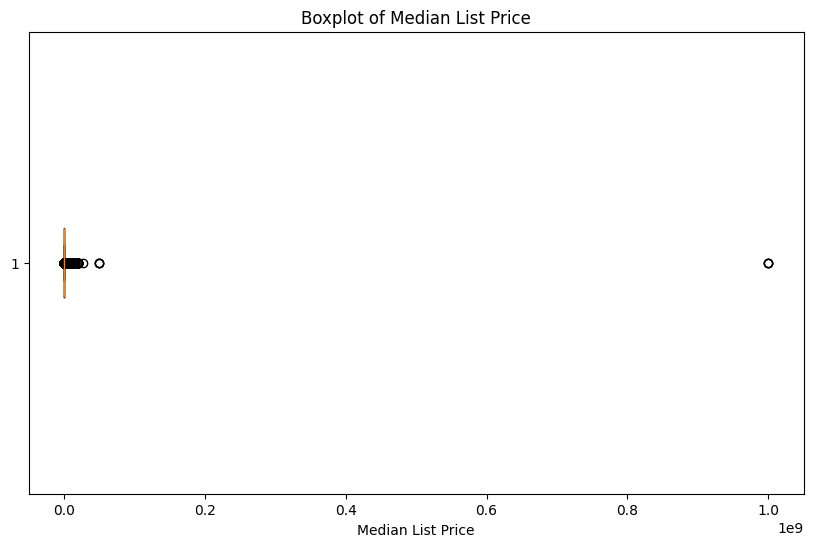

In [91]:
# Visualize outliers in median_list_price
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.boxplot(train_df['median_list_price'].dropna(), vert=False)
plt.title('Boxplot of Median List Price')
plt.xlabel('Median List Price')
plt.show()

In [92]:
top_1_percent = train_df.nlargest(int(0.01 * len(train_df)), 'median_list_price')
print(top_1_percent['median_list_price'].value_counts().sort_index(ascending=False))

median_list_price
999999999.0     3
50449949.5      3
27800000.0      1
19990000.0     38
15849000.0      1
               ..
1754500.0       2
1754000.0       2
1752500.0       2
1750695.0       1
1750000.0      44
Name: count, Length: 1655, dtype: int64


Action: Shrink the dataset to only include entries where `median_list_price` is below $16,000,000 to mitigate the impact of extreme outliers on our analysis and modeling efforts.

In [104]:
train_df = train_df[train_df['median_list_price'] <= 16_000_000].copy()
eval_df = validation_df[validation_df['median_list_price'] <= 16_000_000].copy()
test_df = test_df[test_df['median_list_price'] <= 16_000_000].copy()

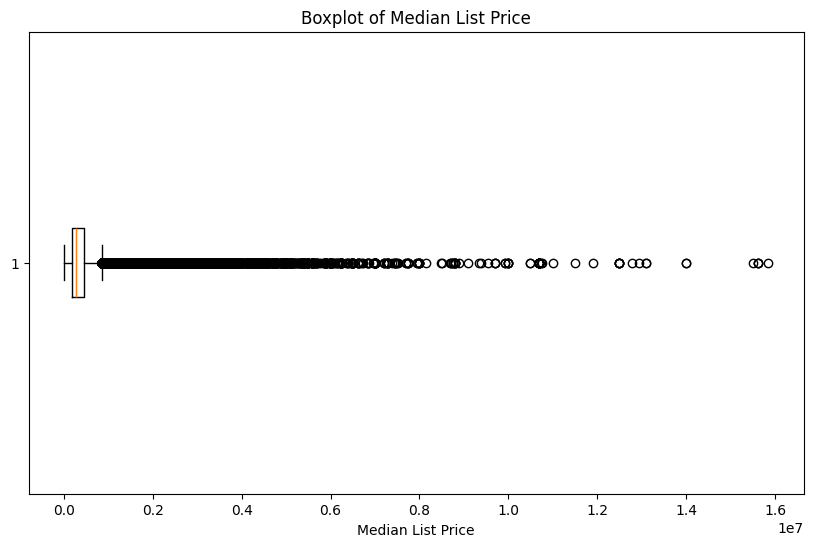

In [98]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.boxplot(train_df['median_list_price'].dropna(), vert=False)
plt.title('Boxplot of Median List Price')
plt.xlabel('Median List Price')
plt.show()

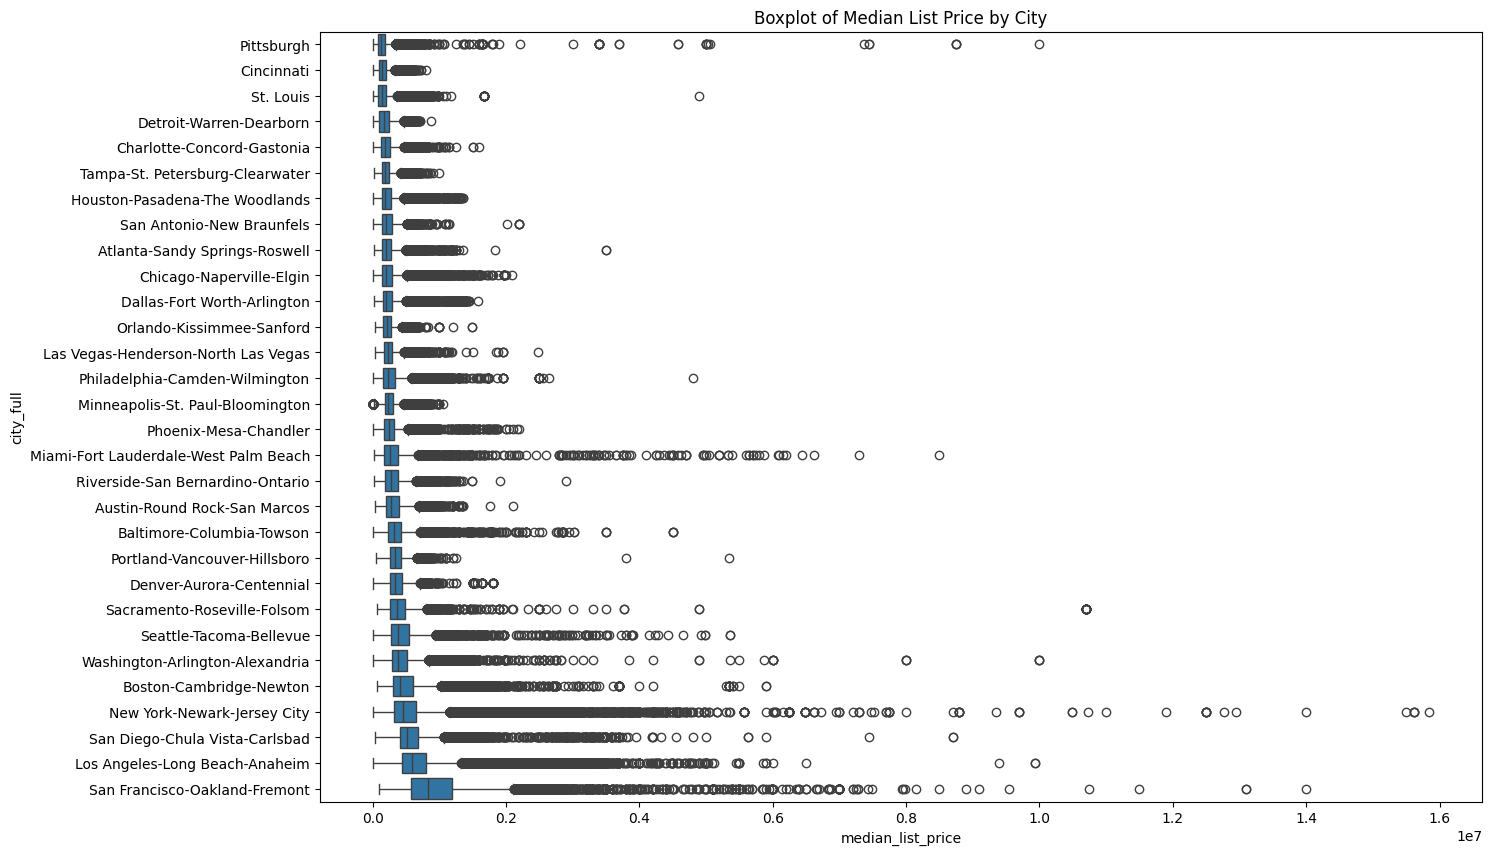

In [ ]:
# Boxplot of house prices for the cities, ordered by median price, for each metro region
import seaborn as sns
plt.figure(figsize=(15, 10))
sns.boxplot(data=train_df, x='median_list_price', y='city_full', order=train_df.groupby('city_full')['median_list_price'].median().sort_values().index)
plt.title('Boxplot of Median List Price by City')
plt.show()

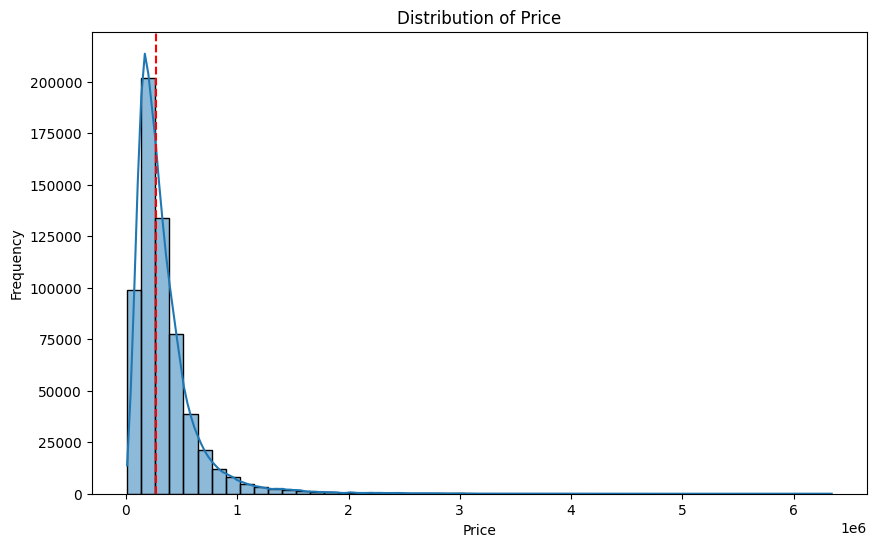

In [103]:
# Distribution of house prices across the dataset 
plt.figure(figsize=(10, 6))
sns.histplot(train_df['price'], bins=50, kde=True)
median_price = train_df['price'].median()
plt.axvline(median_price, color='r', linestyle='--', label=f'Median Price: {median_price:.2f}')
plt.title('Distribution of Price')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

In [105]:
# Save cleaned datasets
train_df.to_csv('../data/processed/HouseTS_train_cleaned.csv', index=False)
eval_df.to_csv('../data/processed/HouseTS_validation_cleaned.csv', index=False)
test_df.to_csv('../data/processed/HouseTS_test_cleaned.csv', index=False)